# Astronomical image reduction
---

Authors:

- João Aires (UFRN)
- Leonardo Almeida (ECT/UFRN) 

Hi there, welcome to the Astronomical image reduction code!

In this notebook we will do a step-by-step tutorial on how to reduce astronomical images. We divide this tutorial in the following steps:

1. Organizing the data;

2. Creating master calibration files;

3. Removing flats and bias from your images;

4. Aligning images;

5. Combining images and background determination.

All observational files necessary to run this entire tutorial are in the ```Data``` folder, make sure that all required files were downloaded. 

_(Obs: ```I'm using a Windows machine```, so the folder path separation is ```\\```, however for linux users, this needs to be changed to ```/```)_

Once all that has been done, lets start this tutorial.


## 0. Importing libraries
---

To this tutorial works properly in your machine, make sure that the following packages are installed in your python enviroment:

 - ```os```: to deal with operating system dependent funcionalities;

 - ```glob```: to find files in some specific path;

 - ```time```: for process duration account;
 
 - ```IPython```: to deal with text displays;
 
 - ```numpy```: for numerical computations;
 
 - ```matplotlib```: for plots;
 
 - ```astropy```: to deal with astronomical quantities and units;
 
 - ```photutils```: provides tools to perform photometry;
 
 - ```astroalign```: to align images;
 
 - ```ccdproc```: tools for processing of CCD images; 

 - ```warnings```: to ignore astropy warnings.

 - ```concurrent```: to allow process parellization;

 - ```shutil```: to move files between paths

After make sure that all above libraries are intalled, lets import them:

In [15]:
import os
import glob
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import astroalign as aa
import ccdproc
from astropy import units as u
from astropy import table
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.stats import SigmaClip, mad_std
from photutils.background import Background2D, SExtractorBackground, \
                                 MeanBackground, MedianBackground, \
                                 StdBackgroundRMS, MADStdBackgroundRMS
import warnings
from concurrent.futures import ThreadPoolExecutor

warnings.filterwarnings('ignore', category=AstropyWarning)

Optionally, you can configure the matplotlib plot style. In this tutorial, we will use the following plot style (make sure that you have the ```Calibri``` font installed on your machine; if you are a Windows user, you don't need to worry about this):

In [3]:
def style():
    plt.rc("lines", linewidth=1.0, linestyle="-", color="black")
    plt.rc("font", family="Calibri", weight="light", size=11.0)
    plt.rc(
        "axes",
        edgecolor="black",
        facecolor="white",
        linewidth=.8,
        grid=False,
        titlesize="x-large",
        titleweight='light',
        labelsize="x-large",
        labelweight="light",
        labelcolor="black",
    )
    plt.rc('figure', facecolor='white')
    plt.rc("mathtext", fontset='custom', rm='Calibri')
    plt.rc("axes.formatter", limits=(-4, 4))
    plt.rc(("xtick", "ytick"), labelsize=12, direction="in", color='black')
    plt.rc("xtick", top=True)
    plt.rc("ytick", right=True)
    plt.rc(("xtick.major", "ytick.major"), size=8, pad=6, width=.8)
    plt.rc(("xtick.minor", "ytick.minor"), size=3, pad=6, width=.8, visible=True)
    plt.rc("legend", numpoints=1, fontsize="x-large", shadow=False, frameon=False)

style()

## 1. Organizing the data
---

If you downloaded the ```Data``` folder, you may notice that there are two directories: ```fab```, where flats and bias images were stored and ```target```, where the star images are. 

In my machine, the ```Data``` folder is at: _~\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\_ (be careful to set the path correctly when run the tutorial). 

Lets store the basic paths and create new directories to store raw, reduced and temporary data:

In [ ]:
# Basic directories
base_dir = os.path.expanduser('~\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\') # Path to the Data folder
fab_dir = os.path.join(base_dir, 'fab')             # Path to the fab folder
target_dir = os.path.join(base_dir, 'target')       # Path to the target folder


# Target basic directories that will be created
raw_dir = os.path.join(target_dir, 'raw')           # Path to the raw target data folder 
reduced_dir = os.path.join(target_dir, 'reduced')   # Path to the reduced target data folder
tmp_dir = os.path.join(target_dir, 'tmp')           # Path to the temporary target data folder


# Create directories
os.makedirs(raw_dir, exist_ok=True)  
os.makedirs(reduced_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)


# Print summary of directories
print('Directories')
print('----------------------')
print('FaB: \t\t\t', fab_dir)
print('Target: \t\t', target_dir)
print('Raw: \t\t\t', raw_dir)
print('Reduced: \t\t', reduced_dir)
print('Tmp: \t\t\t', tmp_dir)
print('----------------------')


# Verify if the files are in the correct directories
if (not glob.glob(target_dir+'\\*.fits')) & (os.listdir(raw_dir) != []):
    print('Files already in \t', raw_dir)
elif (not glob.glob(target_dir+'\\*.fits')) & (os.listdir(raw_dir) == []):
    print('Files do not exist!')
else:
    files_to_move = [os.path.split(f)[1] for f in glob.glob(target_dir+'\\*.fits')]
    
    def move_file(file_name):
        source_file = os.path.join(target_dir, file_name)
        destination_file = os.path.join(raw_dir, file_name)
        os.replace(source_file, destination_file)
    
    with ThreadPoolExecutor() as executor:
        executor.map(move_file, files_to_move)

    print('Files were moved to \t', raw_dir)

Directories
----------------------
FaB: 			 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\fab
Target: 		 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\target
Raw: 			 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\target\raw
Reduced: 		 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\target\reduced
Tmp: 			 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\target\tmp
----------------------
Files were moved to 	 C:\Users\joaov\Documents\Astro\Photometry\reduction_tutorial\Data\target\raw


Now with the basic paths in hand and the files already in its corresponding folder, lets create an array with the paths of each flats, bias and raw target files:

In [11]:
# Get the full path of all files with the specific path in ()
flats = glob.glob(fab_dir+'\\flat_*.fits')
bias  = glob.glob(fab_dir+'\\bias_*.fits')
raw   = glob.glob(raw_dir+'\\*.fits')


# Print the summary of those files
print('Files count')
print('----------------------')
print(f'Flats \t\t {len(flats)}')
print(f'Bias \t\t {len(bias)}')
print(f'Raw \t\t {len(raw)}')
print('----------------------')

Files count
----------------------
Flats 		 20
Bias 		 30
Raw 		 347
----------------------


That's exactly what we expected: 20 flat images, 30 bias images and 347 raw target images.

If you are curious to see what is in each of the variables above defined, we will show you:

In [10]:
bias[:5]

['C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\fab\\bias_001.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\fab\\bias_002.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\fab\\bias_003.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\fab\\bias_004.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\fab\\bias_005.fits']

Exactly! Those are the paths to all bias images (the same goes to ```flats``` and ```raw``` variables defined).

## 2. Creating ```master``` calibration files
---

What do we mean by a ```master``` calibration file? A average combination of calibration images, that is, flats and bias images. 

As you may remember, flats and bias are another names to telescope and camera (CCD), respectively, noise (or effects). When taking astronomical images on a telescope, the structure of the instrument and the camera used, generates noises that needs to be corrected. In a simple terms, a raw astronomical image is a combination of factors that can be expressed as

$$\boxed{\rm \text{raw image} = \text{bias} + \text{flat} \times \left(\text{sky} + \text{stars}\right)}$$

where the ```sky``` is the background sky in the image (there's also a ```noise``` that is unremovable and is present in each one of the above terms).

This is the main goal of the reduction procedure: remove all effects/noise that comes from the instrument.

But why take so many bias and flat images? Using a single bias and flat image to calibration, actually increases the noise in the astronomical image. However, when you use a average combination of bias (or flats), the noise in the images is reduced by a factor of $1/\sqrt{N}$, where $N$ is the number of calibration images.

With that being said, lets create the ```masterbias``` and ```masterflat``` files that will be fundamental to remove them from our images:

In [13]:
# Store the gain used in the observation
gain = 1.2 * u.electron / u.adu

In [20]:
# Start the time count
start = time.time()


# Correct the bias files by the gain
biaslist = []
i = 1
for b in bias:
    bias_ = ccdproc.CCDData.read(b, unit='adu') 
    bias_ = ccdproc.gain_correct(bias_, gain)
    biaslist.append(bias_)
    print(f'Completed [{i}/{len(bias)}] ...')
    i+=1


# Clear the Completed mensage
clear_output(wait=False)


# Creates the masterbias file by average combining bias images
masterbias = ccdproc.combine(biaslist, method='average', sigma_clip=True, 
                             sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)


# Add informations on the masterbias fits image header and save the file in fab folder.
masterbias.meta['Combined'] = True
masterbias.meta['Gain corrected'] = True
masterbias.write(fab_dir+'\\masterbias.fits', overwrite=True)


# Print information on masterbias file
print('Masterbias created!')
print('------------------------------------------------------------')
print(f'MEAN: {np.mean(masterbias.data)}        MEDIAN: {np.median(masterbias.data)}')
print('------------------------------------------------------------')


# End time count and print compilation time
end = time.time()
print('')
print(f'Compilation time: {end-start} s')

Masterbias created!
------------------------------------------------------------
MEAN: 2043.7713352840788        MEDIAN: 2043.7600000000004
------------------------------------------------------------

Compilation time: 14.410221099853516 s


Now the ```masterbias``` file is created and saved. The process of creating the ```masterflat``` file is almost the same, the only difference is that we want to normalize it in order to increase/decrease the pixel sensibility (counts) in the regions of the image that recieves less/more light due to the instrument structure.

Lets do this:

In [21]:
# Start the time count
start = time.time()


# Function to normalize the flat
def inverse_median(a):
    return 1 / np.median(a)


# Correct the flat files by the gain and subtract the bias from it
flatlist = []
i = 1
for f in flats:
    flat_ = ccdproc.CCDData.read(f, unit='adu') 
    flat_ = ccdproc.gain_correct(flat_, gain)
    flat_ = ccdproc.subtract_bias(flat_, masterbias)
    flatlist.append(flat_)
    print(f'Completed [{i}/{len(flats)}] ...')
    i+=1


# Clear the completed mensage
clear_output(wait=False)


# Create the normalized masterflat file by average combining flat images
masterflat = ccdproc.combine(flatlist, method='average', 
                             scale=inverse_median, sigma_clip=True, 
                             sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)


# Add informations on the masterflat fits image header and save the file in fab folder.
masterflat.meta['Combined'] = True
masterflat.meta['Gain corrected'] = True
masterflat.meta['Bias subtracted'] = True
masterflat.write(fab_dir+'\\masterflat.fits', overwrite=True)


# Print information on masterbias file
print('Masterflat created!')
print('------------------------------------------------------------')
print(f'MEAN: {np.mean(masterflat.data)}        MEDIAN: {np.median(masterflat.data)}')
print('------------------------------------------------------------')


# End time count and print compilation time
end = time.time()
print('')
print(f'Compilation time: {end-start} s')

Masterflat created!
------------------------------------------------------------
MEAN: 0.9964577615137882        MEDIAN: 1.0002252809590495
------------------------------------------------------------

Compilation time: 14.57027292251587 s


As you can see, the ```masterflat``` file is indeed normalized!

If you are curious to see what those master files looks like, we will plot them now: 

Text(0, 0.5, 'Count')

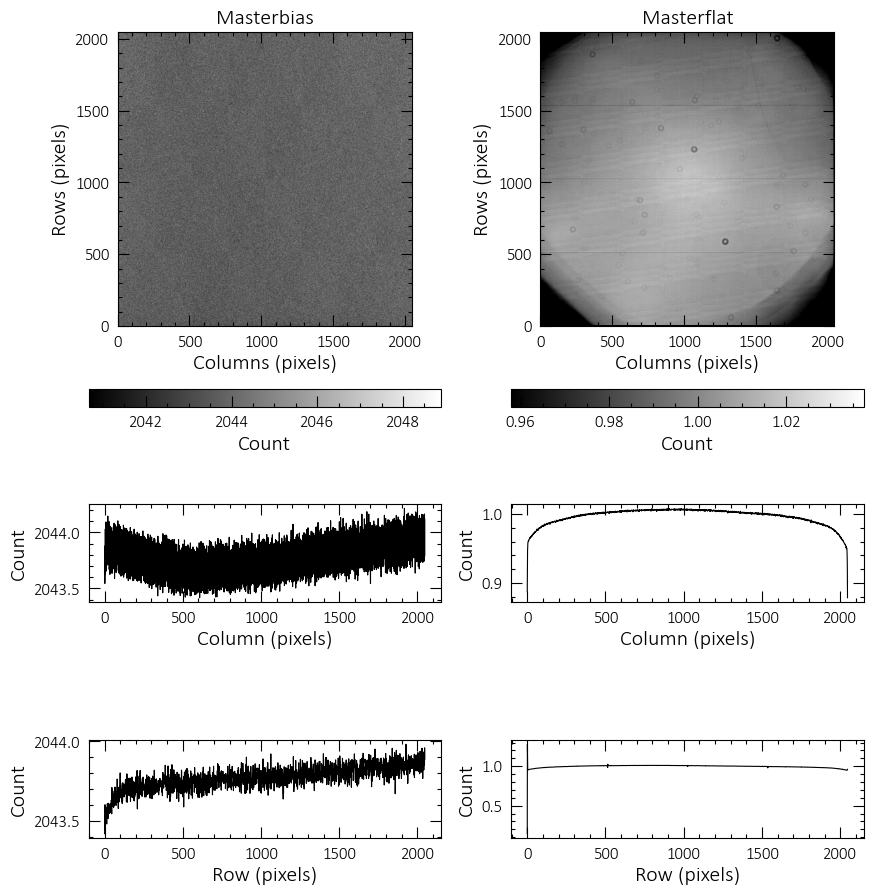

In [36]:
# Masterflat and masterbias plot
fig = plt.figure(figsize=(10,12))


# Masterbias plot
ax1 = plt.subplot(221)
vmin = np.percentile(masterbias.data, 5)
vmax = np.percentile(masterbias.data, 99.5)
im1 = ax1.imshow(masterbias, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
fig.colorbar(im1, orientation='horizontal', label='Count')
ax1.set_title('Masterbias')
ax1.set_xlabel('Columns (pixels)')
ax1.set_ylabel('Rows (pixels)')


# Masterflat plot
ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
vmin = np.percentile(masterflat.data, 5)
vmax = np.percentile(masterflat.data, 99.5)
im2 = ax2.imshow(masterflat, cmap='gray', vmin=vmin, vmax=vmax, origin='lower')
fig.colorbar(im2, orientation='horizontal', label='Count')
ax2.set_title('Masterflat')
ax2.set_xlabel('Columns (pixels)')
ax2.set_ylabel('Rows (pixels)')


# Masterbias column mean count
ax3 = plt.subplot(8,2,9)
ax3.plot(np.mean(masterbias.data, axis=0), c='k', lw=.8)
ax3.set_xlabel('Column (pixels)')
ax3.set_ylabel('Count')


# Masterbias row mean count
ax4 = plt.subplot(8,2,13)
ax4.plot(np.mean(masterbias.data, axis=1), c='k', lw=.8)
ax4.set_xlabel('Row (pixels)')
ax4.set_ylabel('Count')


# Masterflat column mean count
ax5 = plt.subplot(8,2,10)
ax5.plot(np.mean(masterflat.data, axis=0), c='k', lw=.8)
ax5.set_xlabel('Column (pixels)')
ax5.set_ylabel('Count')


# Masterflat row mean count
ax6 = plt.subplot(8,2,14)
ax6.plot(np.mean(masterflat.data, axis=1), c='k', lw=.8)
ax6.set_xlabel('Row (pixels)')
ax6.set_ylabel('Count')

You can see that the darker/brighter regions in the images are where the light received is lower/higher.

Now we are ready to the next step in this tutorial:

## 3. Removing flats and bias from your images
---

Now that we have created and saved the master files, we can import those files using the ```ccdproc.CCDData.read()``` function (this will be important if the process of creating master files takes a lot of time and multiple targets were observed with same instrument configuration, then you only need to create master files once and, when you start the reduction of other targets, you can skip the part where master files were created):

In [40]:
# Open master files using ccdproc.CCDData.read() function 
masterbias = ccdproc.CCDData.read(fab_dir+'\\masterbias.fits')
masterflat = ccdproc.CCDData.read(fab_dir+'\\masterflat.fits')

Now we can calibrate the target images so that the final product is an image with only ```sky``` and ```stars```. If you solve the equation in the begining of ```Section 2```, the $\rm \text{sky}+\text{stars}$ is obtained by:

$$\boxed{\rm \text{sky} + \text{stars} = \frac{\text{raw image} - \text{bias}}{\text{flat}}}$$

that is, we need to subtract the bias from the image and then, divide the resulting image by the flat, so that CCD noise (bias) is removed and all pixels in the image have the same sensibility to light.

So, lets do this:

In [41]:
# Start the time count.
start = time.time()


# Calibration of the astronomical images.
i=1
for r in raw:

    # Print which image is being calibrated.
    print(f'Calibrando [{i}/{len(raw)}] ...')


    # Gain correcting and removing bias and flat from the raw image.
    raw_ = ccdproc.CCDData.read(r, unit='adu')
    raw_ = ccdproc.gain_correct(raw_, gain)
    raw_ = ccdproc.subtract_bias(raw_, masterbias)
    raw_ = ccdproc.flat_correct(raw_, masterflat)


    # Add informations on the calibrated fits image header.
    raw_.meta['Gain corrected'] = True
    raw_.meta['Bias subtracted'] = True
    raw_.meta['Flat corrected'] = True
    
    
    # Save the file in reduced folder.
    filename_reduced = reduced_dir + f'\\{os.path.split(r)[1]}'
    raw_.write(filename_reduced, overwrite=True)
    print(f'\t Saved in {filename_reduced}')
    i+=1


# Clear the printed mensages. 
clear_output(wait=False)
print('Calibration done!')


# End time count and print compilation time.
end = time.time()
print('')
print(f'Tempo de compilação: {end-start} s')

Calibration done!

Tempo de compilação: 289.5138397216797 s


Now lets create a variable to store the names of all calibrated files:

In [49]:
# Variable to store the paths to calibrated images
calibrated = glob.glob(reduced_dir+f'\\*fits')
calibrated[:5]

['C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\wasp45b_r_001.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\wasp45b_r_002.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\wasp45b_r_003.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\wasp45b_r_004.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\wasp45b_r_005.fits']

For you to see the difference between a calibrated and a non calibrated image, we plot a calibrated and a non calibrated image below:

Text(0, 0.5, 'Rows (pixels)')

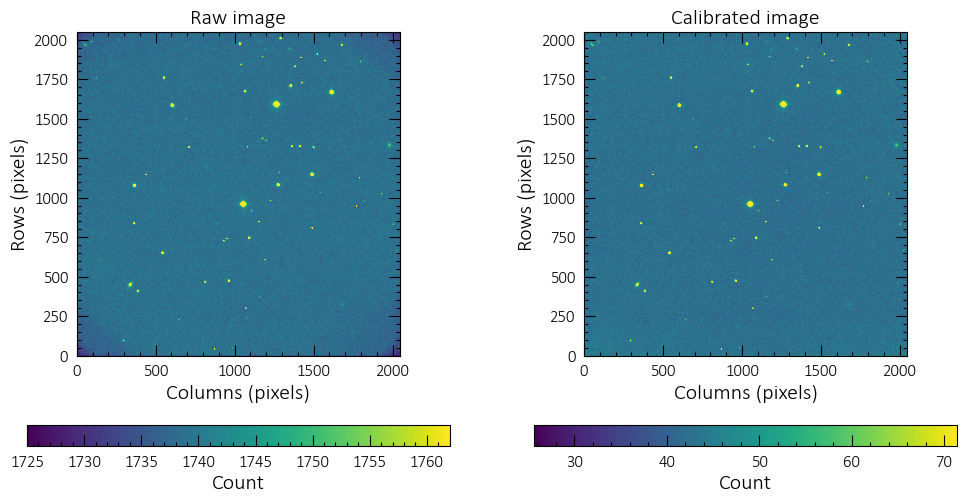

In [50]:
# Create figure
fig = plt.figure(figsize=(12,6))


# Example frames
example_frame_raw = fits.getdata(raw[0])
example_frame_cal = fits.getdata(calibrated[0])


# Plot raw data
ax1 = plt.subplot(121)
vmin = np.percentile(example_frame_raw, 5)
vmax = np.percentile(example_frame_raw, 99.5)
im1 = ax1.imshow(example_frame_raw, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
fig.colorbar(im1, orientation='horizontal', label='Count')
ax1.set_title('Raw image')
ax1.set_xlabel('Columns (pixels)')
ax1.set_ylabel('Rows (pixels)')


# Plot calibrated image
ax2 = plt.subplot(122)
vmin = np.percentile(example_frame_cal, 5)
vmax = np.percentile(example_frame_cal, 99.5)
im2 = ax2.imshow(example_frame_cal, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
fig.colorbar(im2, orientation='horizontal', label='Count')
ax2.set_title('Calibrated image')
ax2.set_xlabel('Columns (pixels)')
ax2.set_ylabel('Rows (pixels)')

That's it, the basic calibration of an astronomical image! 

But are we satisfied with the basics? **No** ...

## 4. Aligning images
---

Sometimes, due to some technical problems, the telescope could not track perfectly the movement of the sky. When this happens, the position of the stars in the image slightly changes from one frame to the other and could generate some problems for future purposes, such as photometry. To avoid these complications, we align the images. This purpose will be achieved with the help of ```astroalign``` package.

First we will create a function to align multiple images.

In [51]:
# Function to align multiple images
def image_alignement(files, folder, idx_reference=0):


    # Reference image
    reference = fits.getdata(files[idx_reference]) + 0


    # Loop to align each image with respect to the reference
    for i in range(len(files)):    


        # Open the file and align it
        file_to_align = fits.getdata(files[i]) + 0
        aligned_file,_ = aa.register(file_to_align, reference)


        # Creates the folder where the aligned images will be stored 
        aligned_dir = os.path.join(folder, 'aligned\\')
        os.makedirs(aligned_dir, exist_ok=True)     


        # Save images
        aligned_filename = aligned_dir+'aligned_'+os.path.split(files[i])[1]
        header_aligned_file = fits.getheader(files[i])
        fits.writeto(aligned_filename, aligned_file, header_aligned_file, overwrite=True)


        # Print the alignement status 
        print(f'{i+1}/{len(files)}')


    # Clear the prints
    clear_output(wait=False)
    print('Alignement done!')


    return glob.glob(aligned_dir+'aligned_*.fits')

Now lets run the function and align all already calibrated images.

In [65]:
aligned = image_alignement(calibrated, reduced_dir)
aligned[:5]

Alignement done!


['C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\aligned\\aligned_wasp45b_r_001.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\aligned\\aligned_wasp45b_r_002.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\aligned\\aligned_wasp45b_r_003.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\aligned\\aligned_wasp45b_r_004.fits',
 'C:\\Users\\joaov\\Documents\\Astro\\Photometry\\reduction_tutorial\\Data\\target\\reduced\\aligned\\aligned_wasp45b_r_005.fits']

## 5. Combining images and background determination
---

Now that we have calibrated aligned images, we can produce a set of images where only stars are present. Star-only images are obtained by subtracting the background (or sky) from the calibrated images.

The first step towards this is determine the background in our images. Similar to what we did while creating the master files, we must first average combine the aligned images in order to obtain a better estimative of the background in those images.

Lets combine the aligned images 2-by-2 (to avoid memory issues):

In [66]:
# Average 2-by-2 combination of images to determine background
for i in range(1, len(aligned)):
    
    
    # Set the file to be combined
    second_file = ccdproc.CCDData.read(aligned[i])
    
    
    # First combination of images
    if i == 1:
        first_file = ccdproc.CCDData.read(aligned[0])
        combined = ccdproc.combine([first_file, second_file], method='average', 
                                    sigma_clip=True, 
                                    sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                    sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
    
    
    # All other combinations
    else:
        combined = ccdproc.combine([combined, second_file], method='average', 
                                    sigma_clip=True, 
                                    sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                    sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)

    
    # Print the current status
    print(f'Combining {i-1} -> {i} ...')


# Clear the prints
clear_output(wait=False)
print('Combination done!')

Combination done!


The combined image is stored in the ```combined``` variable. 

Lets plot the combined image:

c:\Users\joaov\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Text(0, 0.5, 'Rows (pixels)')

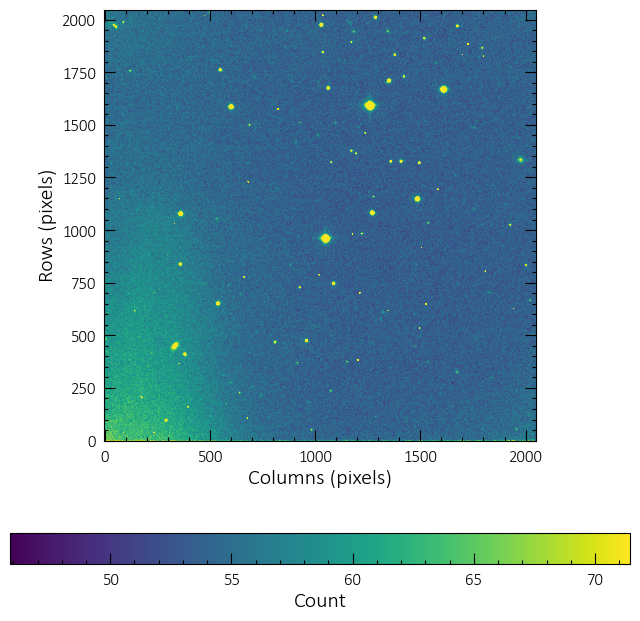

In [68]:
fig = plt.figure(figsize=(8,8))
vmin = np.percentile(combined, 5)
vmax = np.percentile(combined, 99.5)
im1 = plt.imshow(combined, vmin=vmin, vmax=vmax, cmap='viridis', origin='lower')
fig.colorbar(im1, orientation='horizontal', label='Count')
plt.xlabel(r'Columns (pixels)')
plt.ylabel(r'Rows (pixels)')

Now lets determine the background in this image:

In [69]:
# Function to calculate image's background and rms
def background_calculator(data, box_size=64, filter_size=3, mask=None,
                          bkg_method='mode', rms_method='std', sigma_clip=5.0,
                          global_bkg=True):

    
    # List of avaliable background estimating methods
    list_bkg_methods = {'mode': SExtractorBackground,
                        'mean': MeanBackground,
                        'median': MedianBackground}

    
    # List of avaliable rms estimative methods
    list_rms_methods = {'std': StdBackgroundRMS,
                        'mad_std': MADStdBackgroundRMS}

    
    # Converting data into numpy array
    data = np.array(data)

    
    # Verify if bkg and rms methods are valid
    if bkg_method not in list_bkg_methods:
        raise ValueError(f'Invalid background method: {bkg_method}')
    if rms_method not in list_rms_methods:
        raise ValueError(f'Invalid rms method: {rms_method}')

    
    # Creating a sigma clip to filter star signals
    if isinstance(sigma_clip, (tuple, list)):
        sclip = SigmaClip(sigma_lower=sigma_clip[0],
                          sigma_upper=sigma_clip[1])
    else:
        sclip = SigmaClip(sigma=sigma_clip)

    
    # Creating Background2D object using photutils.background
    bkg = Background2D(data, box_size=box_size, filter_size=filter_size,
                       mask=mask, sigma_clip=sclip,
                       bkg_estimator=list_bkg_methods[bkg_method](),
                       bkgrms_estimator=list_rms_methods[rms_method]())

    
    # Estimating the global background (only if you do not want the local estimative)
    if global_bkg:
        return float(bkg.background_median), float(bkg.background_rms_median)
    else:
        return np.array(bkg.background), np.array(bkg.background_rms)


# Store the background into the bkg variable
bkg, rms = background_calculator(combined, global_bkg=False)
print('Background done!')

Background done!


Okay, so now, lets remove the background from our combined image:

In [70]:
bkg_removed_combined = combined - bkg

And, finally, lets see what we've done:

c:\Users\joaov\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Text(0.5, 0, 'Columns (pixels)')

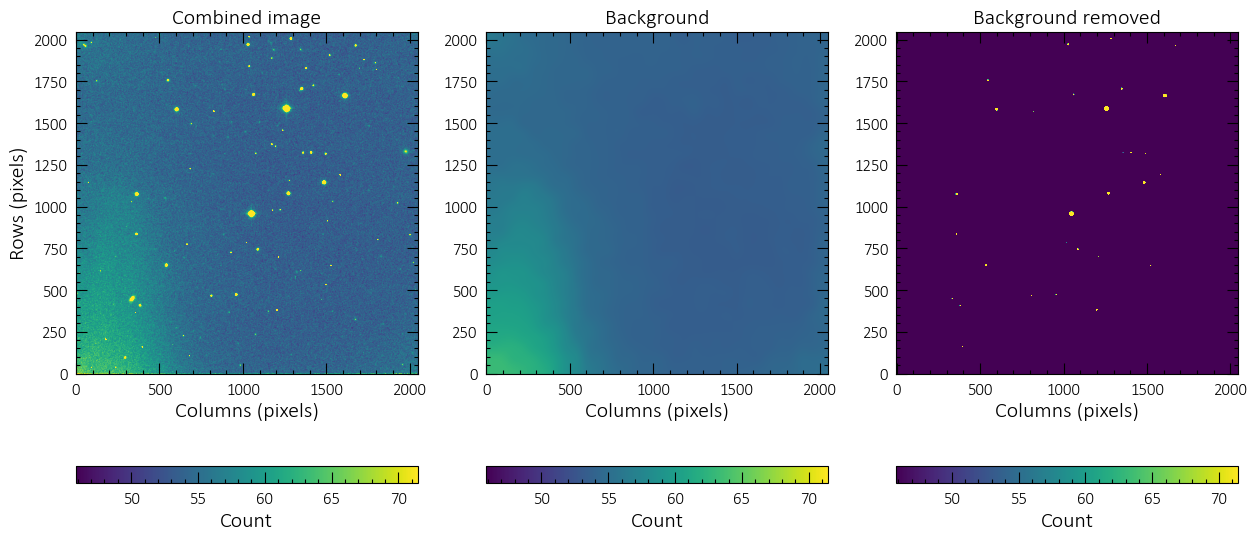

In [72]:
# Creating a figure
fig = plt.figure(figsize=(15,8))


# Lets use the maximum and minimum values from the combined image
vmin = np.percentile(combined, 5)
vmax = np.percentile(combined, 99.5)


# Plot the combined image
ax1 = plt.subplot(131)
im1 = ax1.imshow(combined, vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
fig.colorbar(im1, orientation='horizontal', label='Count')
ax1.set_title('Combined image')
ax1.set_xlabel('Columns (pixels)')
ax1.set_ylabel('Rows (pixels)')


# Plot the background
ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
im2 = ax2.imshow(bkg, vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
fig.colorbar(im2, orientation='horizontal', label='Count')
ax2.set_title('Background')
ax2.set_xlabel('Columns (pixels)')


# Plot the combined image without background
ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
im3 = ax3.imshow(bkg_removed_combined, vmin=vmin, vmax=vmax, origin='lower', cmap='viridis')
fig.colorbar(im3, orientation='horizontal', label='Count')
ax3.set_title('Background removed')
ax3.set_xlabel('Columns (pixels)')

Now, if you remove the background determined above from all you aligned images, you will have reduced images that contains only stars (and the unremovable noise).

That's it, you completed the whole tutorial on astronomical image reduction. In a future notebook i will show you how to produce your own light curve from the data we've worked here!

Thanks for your attention!

Hope it was helpful!

Feel free to send suggestions on optimization of this code.

**João Aires**
